## Data processing

### Include only position players appearing after 1975

In [23]:
import pandas as pd
df = pd.read_csv('bsb_ref.csv')
df = df.fillna(df.mean())     
df = df[df.year_ID >= 1975]    # drop rows before 1975
df = df[df.pitcher == 'N']     # drop pitchers
df = df.sort_values(by=['name_common', 'year_ID'])   # sort values by name

# player MLB ID => player name
playerNameToID = {row['mlb_ID']: row['name_common'] for __, row in df.iterrows()}

df.head()

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,...,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg
27449,A.J. Ellis,27.0,454560.0,ellisaj01,2008,LAD,1,NL,3.0,4,...,4.61849,1.876,1.886,0.4799,0.4799,0.5020,0.4976,-100.0000,1.009,1.268
27450,A.J. Ellis,28.0,454560.0,ellisaj01,2009,LAD,1,NL,10.0,8,...,4.47002,1.858,1.869,0.4764,0.4764,0.5026,0.4959,-45.6488,3.320,4.127
27451,A.J. Ellis,29.0,454560.0,ellisaj01,2010,LAD,1,NL,128.0,44,...,4.29053,1.859,1.851,0.4994,0.5042,0.5007,0.4903,91.0563,40.498,43.783
27452,A.J. Ellis,30.0,454560.0,ellisaj01,2011,LAD,1,NL,103.0,31,...,4.05168,1.836,1.822,0.5055,0.5126,0.4988,0.4885,117.1384,32.762,33.668
27453,A.J. Ellis,31.0,454560.0,ellisaj01,2012,LAD,1,NL,505.0,133,...,4.17112,1.852,1.838,0.5137,0.5121,0.5085,0.4871,117.8717,160.279,171.865


### Filter out players who appeared in 2012-2017

In [27]:
players = sorted(list(set(df.name_common)))     # list of all players
metrics = [col for col in df.columns if df[col].dtype != 'object']    # should have 41 things
years = [2012, 2013, 2014, 2015, 2016, 2017]

In [28]:
df_2012 = pd.DataFrame(columns=df.columns)
df_2013 = pd.DataFrame(columns=df.columns)
df_2014 = pd.DataFrame(columns=df.columns)
df_2015 = pd.DataFrame(columns=df.columns)
df_2016 = pd.DataFrame(columns=df.columns)
df_2017 = pd.DataFrame(columns=df.columns)

# only consider players that appeared in 'years_appeared_in'
def eligible_player(player, years_appeared_in, years_of_interest):
    return set(years_of_interest).issubset(years_appeared_in)

for player in players:
    player_rows = df[df.name_common == player]
    if not eligible_player(player, player_rows.year_ID.values, years):
        continue
    df_2012 = df_2012.append(player_rows[player_rows.year_ID == 2012].head(1))
    df_2013 = df_2013.append(player_rows[player_rows.year_ID == 2013].head(1))
    df_2014 = df_2014.append(player_rows[player_rows.year_ID == 2014].head(1))
    df_2015 = df_2015.append(player_rows[player_rows.year_ID == 2015].head(1))
    df_2016 = df_2016.append(player_rows[player_rows.year_ID == 2016].head(1))
    df_2017 = df_2017.append(player_rows[player_rows.year_ID == 2017].head(1))

In [29]:
df_2012.head()

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,...,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg
27453,A.J. Ellis,31.0,454560.0,ellisaj01,2012,LAD,1,NL,505.0,133,...,4.17112,1.852,1.838,0.5137,0.5121,0.5085,0.4871,117.8717,160.279,171.865
77094,A.J. Pollock,24.0,572041.0,polloaj01,2012,ARI,1,NL,93.0,31,...,4.19596,1.836,1.839,0.4876,0.4841,0.5031,0.4899,89.6687,30.397,33.947
43166,Aaron Hill,30.0,431094.0,hillaa01,2012,ARI,1,NL,668.0,156,...,4.15897,1.857,1.837,0.5194,0.5207,0.5015,0.4858,133.4968,220.377,255.232
26870,Adam Eaton,23.0,594809.0,eatonad02,2012,ARI,1,NL,103.0,22,...,4.15897,1.853,1.837,0.5187,0.5138,0.5073,0.4858,113.9719,33.701,35.624
48493,Adam Jones,26.0,430945.0,jonesad01,2012,BAL,1,AL,697.0,162,...,4.25092,1.871,1.850,0.5104,0.5188,0.4941,0.4830,124.8557,225.201,269.374


### Drop string-valued columns

In [30]:
df_2012 = df_2012.select_dtypes(exclude=['object'])
df_2013 = df_2013.select_dtypes(exclude=['object'])
df_2014 = df_2014.select_dtypes(exclude=['object'])
df_2015 = df_2015.select_dtypes(exclude=['object'])
df_2016 = df_2016.select_dtypes(exclude=['object'])
df_2017 = df_2017.select_dtypes(exclude=['object'])

# assert OPS+ is actually at the same place in all dataframes
ops_plus_indexes = [df_2012.columns.get_loc('OPS_plus'),
                    df_2013.columns.get_loc('OPS_plus'),
                    df_2014.columns.get_loc('OPS_plus'),
                    df_2015.columns.get_loc('OPS_plus'),
                    df_2016.columns.get_loc('OPS_plus'),
                    df_2017.columns.get_loc('OPS_plus')]
ops_plus_index = ops_plus_indexes[0]
for i in range(1, len(ops_plus_indexes)):
    assert ops_plus_index == ops_plus_indexes[i]
    
print('ops_plus_index = ', ops_plus_index)

ops_plus_index =  38


### Convert to numpy arrays

In [31]:
np_2012 = df_2012.to_numpy()
np_2013 = df_2013.to_numpy()
np_2014 = df_2014.to_numpy()
np_2015 = df_2015.to_numpy()
np_2016 = df_2016.to_numpy()
np_2017 = df_2017.to_numpy()

print('np_2013 shape = ', np_2013.shape)
print('np_2014 shape = ', np_2014.shape)
print('np_2015 shape = ', np_2015.shape)
print('np_2016 shape = ', np_2016.shape)
print('np_2017 shape = ', np_2017.shape)

np_2013 shape =  (222, 41)
np_2014 shape =  (222, 41)
np_2015 shape =  (222, 41)
np_2016 shape =  (222, 41)
np_2017 shape =  (222, 41)


### Smush data into [0, 1]

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
np_2012_scaled = scaler.fit_transform(np_2012)
np_2013_scaled = scaler.fit_transform(np_2013)
np_2014_scaled = scaler.fit_transform(np_2014)
np_2015_scaled = scaler.fit_transform(np_2015)
np_2016_scaled = scaler.fit_transform(np_2016)
np_2017_scaled = scaler.fit_transform(np_2017)

### Split into train and test sets

In [33]:
import numpy as np
np_X = np.stack([np_2012_scaled, np_2013_scaled, np_2014_scaled, 
                 np_2015_scaled, np_2016_scaled], axis=1)
np_y = np_2017_scaled[:,ops_plus_index]

print('np_X shape = ', np_X.shape)
print('np_y shape = ', np_y.shape)

np_X shape =  (222, 5, 41)
np_y shape =  (222,)


In [34]:
player_count, __, __ = np_X.shape
train_size = int(player_count*0.8)

X_train = np_X[:train_size,...]
y_train = np_y[:train_size,...]
X_test = np_X[train_size:,...]
y_test = np_y[train_size:,...]

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (177, 5, 41)
y_train shape =  (177,)
X_test shape =  (45, 5, 41)
y_test shape =  (45,)


## RNN with LSTM

### Build model

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))

model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.6))

model.add(LSTM(units=50))
model.add(Dropout(0.8))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 50)             18400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)               

### Train model

In [36]:
model.fit(X_train, y_train, epochs=300, batch_size=32)

Epoch 1/300
177/177 [==============================] - 2s 11ms/step - loss: 0.0482
Epoch 2/300
177/177 [==============================] - 0s 467us/step - loss: 0.0216
Epoch 3/300
177/177 [==============================] - 0s 471us/step - loss: 0.0204
Epoch 4/300
177/177 [==============================] - 0s 452us/step - loss: 0.0171
Epoch 5/300
177/177 [==============================] - 0s 431us/step - loss: 0.0147
Epoch 6/300
177/177 [==============================] - 0s 444us/step - loss: 0.0137
Epoch 7/300
177/177 [==============================] - 0s 433us/step - loss: 0.0151
Epoch 8/300
177/177 [==============================] - 0s 438us/step - loss: 0.0148
Epoch 9/300
177/177 [==============================] - 0s 437us/step - loss: 0.0134
Epoch 10/300
177/177 [==============================] - 0s 412us/step - loss: 0.0119
Epoch 11/300
177/177 [==============================] - 0s 440us/step - loss: 0.0136
Epoch 12/300
177/177 [==============================] - 0s 421us/step - los

177/177 [==============================] - 0s 436us/step - loss: 0.0069
Epoch 98/300
177/177 [==============================] - 0s 428us/step - loss: 0.0065
Epoch 99/300
177/177 [==============================] - 0s 414us/step - loss: 0.0064
Epoch 100/300
177/177 [==============================] - 0s 412us/step - loss: 0.0061
Epoch 101/300
177/177 [==============================] - 0s 413us/step - loss: 0.0069
Epoch 102/300
177/177 [==============================] - 0s 414us/step - loss: 0.0064
Epoch 103/300
177/177 [==============================] - 0s 410us/step - loss: 0.0062
Epoch 104/300
177/177 [==============================] - 0s 419us/step - loss: 0.0066
Epoch 105/300
177/177 [==============================] - 0s 412us/step - loss: 0.0068
Epoch 106/300
177/177 [==============================] - 0s 435us/step - loss: 0.0066
Epoch 107/300
177/177 [==============================] - 0s 421us/step - loss: 0.0063
Epoch 108/300
177/177 [==============================] - 0s 419us/step

177/177 [==============================] - 0s 412us/step - loss: 0.0055
Epoch 193/300
177/177 [==============================] - 0s 404us/step - loss: 0.0047
Epoch 194/300
177/177 [==============================] - 0s 404us/step - loss: 0.0043
Epoch 195/300
177/177 [==============================] - 0s 407us/step - loss: 0.0027
Epoch 196/300
177/177 [==============================] - 0s 383us/step - loss: 0.0034
Epoch 197/300
177/177 [==============================] - 0s 383us/step - loss: 0.0027
Epoch 198/300
177/177 [==============================] - 0s 407us/step - loss: 0.0022
Epoch 199/300
177/177 [==============================] - 0s 402us/step - loss: 0.0024
Epoch 200/300
177/177 [==============================] - 0s 401us/step - loss: 0.0027
Epoch 201/300
177/177 [==============================] - 0s 403us/step - loss: 0.0035
Epoch 202/300
177/177 [==============================] - 0s 436us/step - loss: 0.0083
Epoch 203/300
177/177 [==============================] - 0s 412us/st

177/177 [==============================] - 0s 452us/step - loss: 0.0029
Epoch 288/300
177/177 [==============================] - 0s 446us/step - loss: 0.0026
Epoch 289/300
177/177 [==============================] - 0s 453us/step - loss: 0.0026
Epoch 290/300
177/177 [==============================] - 0s 436us/step - loss: 0.0035
Epoch 291/300
177/177 [==============================] - 0s 410us/step - loss: 0.0035
Epoch 292/300
177/177 [==============================] - 0s 408us/step - loss: 0.0026
Epoch 293/300
177/177 [==============================] - 0s 405us/step - loss: 0.0023
Epoch 294/300
177/177 [==============================] - 0s 429us/step - loss: 0.0023
Epoch 295/300
177/177 [==============================] - 0s 415us/step - loss: 0.0041
Epoch 296/300
177/177 [==============================] - 0s 462us/step - loss: 0.0024
Epoch 297/300
177/177 [==============================] - 0s 957us/step - loss: 0.0173
Epoch 298/300
177/177 [==============================] - 0s 508us/st

### Evaluate model

In [37]:
from sklearn.metrics import r2_score, mean_squared_error
def evaluate(y_pred, y_actual, name):
    print(name)
    print('*'*50)
    print('R2 score = ', r2_score(y_actual, y_pred))
    print('MSE = ', mean_squared_error(y_actual, y_pred))
    num_examples = y_actual.shape[0]
    for i in range(num_examples):
        print('Predicted = {}; Actual = {}'.format(y_pred[i,0], y_actual[i]))

#### Test set

In [38]:
y_test_pred = model.predict(X_test)
evaluate(y_test_pred, y_test, 'TEST')

TEST
**************************************************
R2 score =  0.10047383329851234
MSE =  0.0018777207575421922
Predicted = 0.2973616123199463; Actual = 0.35159855237501586
Predicted = 0.26600950956344604; Actual = 0.23787307624221282
Predicted = 0.28643062710762024; Actual = 0.2625763317031632
Predicted = 0.283346563577652; Actual = 0.2574209363138247
Predicted = 0.2829911410808563; Actual = 0.20990268859077602
Predicted = 0.3260660171508789; Actual = 0.34042660012538434
Predicted = 0.28796514868736267; Actual = 0.294078899538986
Predicted = 0.20236006379127502; Actual = 0.31731151354792986
Predicted = 0.22738173604011536; Actual = 0.23332161862495188
Predicted = 0.2741515636444092; Actual = 0.20242168451203624
Predicted = 0.2596336007118225; Actual = 0.24191090149245167
Predicted = 0.2902825176715851; Actual = 0.2953229624476221
Predicted = 0.26062852144241333; Actual = 0.20411613340292611
Predicted = 0.28444021940231323; Actual = 0.2645579974238509
Predicted = 0.294616937637329

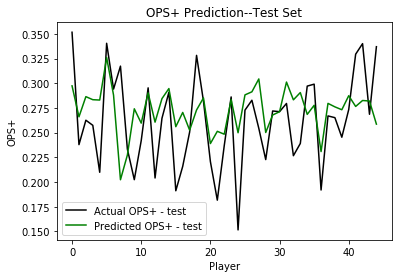

In [41]:
import matplotlib.pyplot as plt
plt.plot(y_test, color='black', label = 'Actual OPS+ - test')
plt.plot(y_test_pred, color='green', label = 'Predicted OPS+ - test')
plt.title('OPS+ Prediction--Test Set')
plt.xlabel('Player')
plt.ylabel('OPS+')
plt.legend()
plt.show()

#### Train set

In [42]:
y_train_pred = model.predict(X_train)
evaluate(y_train_pred, y_train, 'TRAIN')

TRAIN
**************************************************
R2 score =  0.22201309216513354
MSE =  0.005433147701151346
Predicted = 0.24846966564655304; Actual = 0.243153008327332
Predicted = 0.28625187277793884; Actual = 0.27256974951497526
Predicted = 0.2581946849822998; Actual = 0.15806494099666524
Predicted = 0.30718034505844116; Actual = 0.3043158485333848
Predicted = 0.2864985764026642; Actual = 0.2890449437286482
Predicted = 0.2859348654747009; Actual = 0.30858905465889497
Predicted = 0.24083513021469116; Actual = 0.18708019804594753
Predicted = 0.26834264397621155; Actual = 0.2433898562579201
Predicted = 0.2867608070373535; Actual = 0.32520003299244404
Predicted = 0.28675150871276855; Actual = 0.22364003157103043
Predicted = 0.28131958842277527; Actual = 0.24038516396299242
Predicted = 0.2777804136276245; Actual = 0.21722247959081545
Predicted = 0.2510867714881897; Actual = 0.17228787928677639
Predicted = 0.2665696442127228; Actual = 0.2647425203814735
Predicted = 0.27922996878623

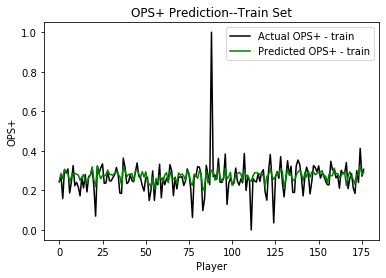

In [43]:
import matplotlib.pyplot as plt
plt.plot(y_train, color='black', label = 'Actual OPS+ - train')
plt.plot(y_train_pred, color='green', label = 'Predicted OPS+ - train')
plt.title('OPS+ Prediction--Train Set')
plt.xlabel('Player')
plt.ylabel('OPS+')
plt.legend()
plt.show()